In [7]:
import os
import time
import networkx as nx
import numpy as np
import scipy
from scipy import sparse
from scipy import linalg
import matplotlib.pyplot as plt
import re
import random
import networkx as nx
%matplotlib inline

# The following lines are needed to stop a known issue where 
# networkx causes matplotlib to crash on mac.
from sys import platform as sys_pf
if sys_pf == 'darwin':
    import matplotlib
    matplotlib.use("TkAgg")


In [8]:
# pageRankAlg() takes as input a matrix A whose elements are all 0 or 1. A is the transpose of the adjacency
# matrix for a web graph. That is, A_{i,j} = 1 if node j has a hyperlink to node i.
# pageRankAlg the PageRank algorithm via the power method. max_iters sets an upper bound on the number of iterations
# to run the power method for. During the execution of the power method if the dominant eigenvalue approximation 
# from the k-1th step differs from the approximation of the kth step by <= tolerance we have reached convergence
# and the algorithm will stop .
# If this never occurs the algorithm will run for max_iters iterations.
# The output is the scoring eigenvector associated with the dominant eigenvalue as well as the page ranking vector
# determined by the scoring vector. 

def pageRankAlg(A, max_iters = 1000, tolerance = 1e-6):
    
    if type(A) is not scipy.sparse.csr.csr_matrix:
        A = sparse.csr_matrix(A) # Use sparse matrix for faster computation
                
    numElements = A.size # For a sparse matrix .size gives the number of nonzero elements.
    
    # The ith entry of outdegree contains the outdegree of the ith node. We create outdegree
    # by summing each along each column of A
    outdegree = scipy.sparse.csr_matrix.sum(A,axis=0) 
    outdegree = np.array(outdegree).flatten() # Convert to a numpy array
    
    numRows, numCols = A.shape
    
    assert numRows == numCols # Ensure that the matrix A is square
    assert np.max(A) == 1 and np.sum(A) == numElements # Ensure the matrix only contains elements
                                                        # equal to 1 or 0
    n = numCols
    
    s = 0.15 # This value represents the probability that the "random surfer" will 
             # switch to a completely random web page instead of following hyperlinks

    # The initial power method vector will have all elements equal to 1/n and thus has norm 1
    x = np.ones(n).reshape(n, 1)
    x = x / np.linalg.norm(x)
    
    danglingOutdegree = np.copy(outdegree) # danglingOutdegrees holds the outdegree for each node
                                           # after dangling nodes have been addressed
    for j in range(n):
        if outdegree[j] == 0:
            danglingOutdegree[j] += (n - 1) # Add a 1 for every element in the zero column corresponding
                                            # to the dangling node for the n-1 other nodes.
    danglingOutdegree = danglingOutdegree.reshape(n, 1) # Reshape to a vertical vector 

    # This is a list that holds all dangling nodes that we need to address at each iteration
    danglingNodes = list()
    for j in range(n):
        if outdegree[j] == 0:
            danglingNodes.append(j) 
    
    for iteration in range(max_iters):
        prevx = x

        # P@x = ((1 - s)*B + s*(1/n)V)@x = ( (1 - s)*( (A + F) / np.sum(H + F, axis=0) )@x + s*(1/n)V@x = 
        # (1 - s)*( H@w + F@w ) + s*(1/n)V@x
        # where F = (1/n)W   -   B = H + F   -    w = x/np.sum(H + F, axis=0) =  x/danglingOutdegree
      
        # Calculating s*(1/n)V@x
        vSum = np.sum(x)
        sVx = s * np.full((n,1), vSum / n)
        
        # Calculating w. No division by 0 will occur since we've dealth with all dangling nodes.
        w = x / danglingOutdegree
        w = w.reshape(n, 1) 
          
        # Calculating F@w
        danglingSum = w[danglingNodes].sum()
        Fw = np.full((n, 1), danglingSum)
        # Now we have to take out the nodes that point to themselves
        d = np.zeros((n,1))
        d[danglingNodes] = w[danglingNodes]
        # The final vector Fw
        Fw = Fw - d
               
        # Calculating P@x. This one is straignt forward
        Aw = A@w

        # Calculate the new x
        x = (1-s)*(Aw + Fw) + sVx
        
        # Normalize
        eigval = np.linalg.norm(x)
        x = x / eigval
        
        if np.linalg.norm(x - prevx) < tolerance:
            break
    
    if np.linalg.norm(x - prevx) < tolerance:
        print('The dominant eigenvalue is %f after %d iterations.\n' % (eigval, iteration+1))
    else:
        print('The power method did not converge to tolerance %e after %d iterations.\n' % (tolerance, max_iters))
    
    x = x.reshape(1, n)
    x = x.flatten()
    
    # Ensure all eigenvalue elements are the same sign and if needed make them positive.
    assert np.all(x > 0) or np.all(x < 0), 'Error: eigenvector is not all > 0 or < 0'
    vector = np.abs(x)
        
    # Sort the eigenvector from smallest value to largest and reverse the sorting to get the rankings.
    ranking = np.argsort(vector)[::-1]

    return ranking, vector
    

In [10]:
# Load the crawl data: 
%time crawl = open('./crawler/crawl_1_50.txt').read().split("*")

CPU times: user 651 µs, sys: 719 µs, total: 1.37 ms
Wall time: 741 µs


In [11]:
crawl = crawl[1:] # Discard first entry which is a newline 
print(len(crawl)) # We expect 50 entries

50


In [12]:
# for item in crawl:
#     print(item)

In [6]:

# First make an adjacency list. We need to determine all unique pages
pagesMap = {} # This dict is a mapping from url to index. 
pagesList = [] # This will hold our adjacency list.

# For removing any whitespace entries.
def normalizeString(s):
    s = s.strip()
    s = re.sub(r"\s+", r"", s).strip()
    return s

for item in crawl: 
    items = item.split('\n')
    if items[1][0] == "#": # The second entry of a crawl item may start with '#'. This sentry simply contains
        # an alias for the main url. We'll just discard the alias if it exists. 
        items = [items[0]] + items[2:] 
        
    # Remove the 1st entry of the crawl list which just contains metadata along and remove the metadata
    # attached to the first entry
    items = [items[0].split()[1]] + items[2:]
     
    # Ensure the inital url of each item is not whitespace or the newline.
    if normalizeString(items[0]) == "":
        continue # if the main node is an empty string then skip
    
    itemsList = [items[0]] # Add the 0th element which is the node that points to all other nodes
    itemsDict = {items[0]: None} # This dict is used to eliminate any duplicate urls (for node u
    # there can be at most one edge (u,v) for a specific v).             
        
    # Eliminate any loops or duplicate edges
    for urlStr in items[1:]:
        if normalizeString(urlStr) != "" and urlStr not in itemsDict:
            itemsList.append(urlStr)
            itemsDict[urlStr] = None
    pagesList.append(itemsList)   
        
cur_index = 0
# Now give each url a unique index
for entry in pagesList: 
    for urlStr in entry:
        if urlStr not in pagesMap:
            pagesMap[urlStr] = cur_index
            cur_index += 1
   

In [7]:
# Ensure that there are no duplicate indices.
checkerSet = set()
for key, item in pagesMap.items():
    checkerSet.add(item)
assert(len(checkerSet) == len(pagesMap))


In [8]:
print(len(pagesMap))
print(len(pagesList))

1420
50


In [9]:
pageNames = [None]*len(pagesMap)

In [10]:
for key, item in pagesMap.items():
    assert(item != "") # We should have no urls that are whitespace or newlines
    assert(pageNames[item] == None) # Each url should have a unique index
    pageNames[item] = key


In [11]:
# Now create the transpose of the adjacency matrix. pagesList is a list of lists where the 0th entry in any inner
# list is a node and all other entries are nodes the 0th node points to. 
A = np.zeros((len(pagesMap), len(pagesMap)),dtype=int)

for pageList in pagesList: 
    j = pagesMap[pageList[0]]
    for item in pageList[1:]: 
        i = pagesMap[item]
        A[i,j] = 1

In [12]:
print(A.shape)
print(A)

(1420, 1420)
[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [13]:
color_map = [None]*len(pagesMap)
colors = ['orange', 'green', 'lightgreen', 'red', 'blue', 'lightblue', 'purple', 'yellow', 'teal']

for pageList in pagesList:
    color = colors[np.random.randint(len(colors))]
    for entry in pageList:
        color_map[pagesMap[entry]] = color # Color all nodes in an inner list of pageList the same.
        

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


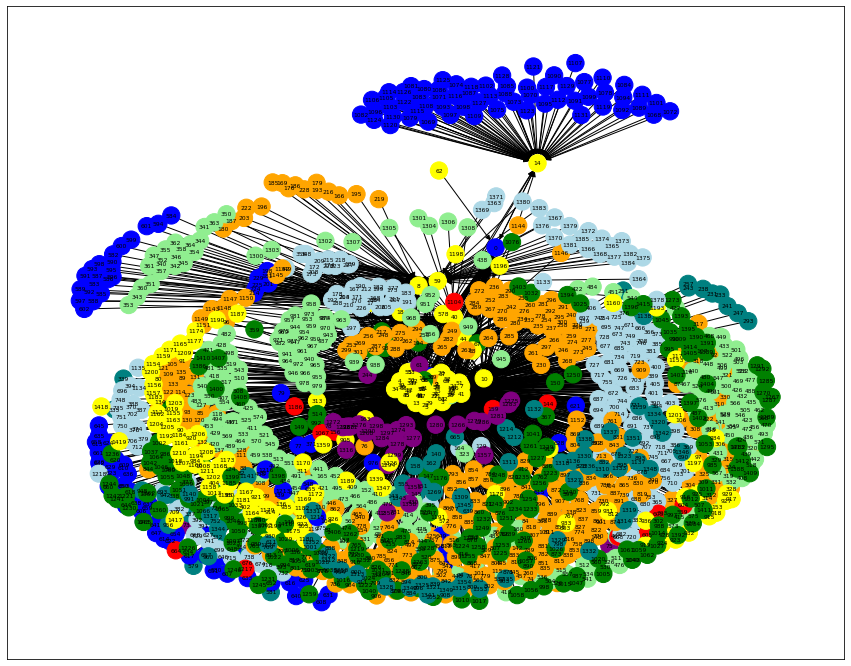

In [16]:
%matplotlib inline

G = nx.DiGraph() 

for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        if A[i,j] != 0:
            G.add_edge(i, j)  

# Trying out different networkx layouts: 
# Layout 1
#pos = nx.spring_layout(G, seed=4321, k=2)

# Layout 2
#pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()))

# Layout 3
# fixedpos = {1:(0,0), 6:(1,1), 11:(1,0), 16:(0,1)}
#pos = nx.spring_layout(G, fixed = fixedpos.keys(), pos = fixedpos)

# Layout 4
pos = nx.spring_layout(G)

fig, ax = plt.subplots(1, 1, figsize=(15, 12));
nx.draw_networkx(G, pos, ax=ax, node_color=color_map, font_size=6)
plt.show()


In [19]:
%time rankVector, scoreVector = pageRankAlg(A) 
num_entries = 20
print("\nFirst {} entries of the rank vector:".format(num_entries), rankVector[:num_entries], "\n")
print("First {} entries of the scoring eigenvector:".format(num_entries), scoreVector[:num_entries], "\n")

for i in range(20):
    print('rank %d is page %3d: %s' % (len(pagesMap) - i, rankVector[i], pageNames[rankVector[i]]))



The dominant eigenvalue is 1.000000 after 11 iterations.

CPU times: user 20.7 ms, sys: 1.23 ms, total: 21.9 ms
Wall time: 20.4 ms

First 20 entries of the rank vector: [ 4 22 53 34 61 55 27 47 46 64 63 31 32 54 15  1 60 28 19 11] 

First 20 entries of the scoring eigenvector: [0.02586559 0.03952779 0.0393979  0.03755709 0.04406905 0.03805639
 0.0393979  0.03833322 0.02689073 0.03937432 0.02798438 0.0393979
 0.03888935 0.03802544 0.02564926 0.03958179 0.03804822 0.02603494
 0.02603494 0.0393979 ] 

rank 1420 is page   4: https://www.ucsb.edu/
rank 1419 is page  22: https://www.ucsb.edu/terms-of-use
rank 1418 is page  53: https://twitter.com/ucsantabarbara
rank 1417 is page  34: https://vimeo.com/ucsantabarbara
rank 1416 is page  61: https://www.facebook.com/ucsantabarbara
rank 1415 is page  55: http://ucsbgauchos.com
rank 1414 is page  27: https://www.linkedin.com/school/ucsantabarbara
rank 1413 is page  47: https://www.instagram.com/ucsantabarbara/
rank 1412 is page  46: http://www.ne